In [1]:
import numpy as np
import cupy as cp
import cv2
import xraylib
from holotomocupy.utils import *

astropy module not found
olefile module not found


In [2]:
ne = 768
n = 256
npos = 1
show = True
path = f'/data/vnikitin/paper/far_field'
voxelsize = 1e-8
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

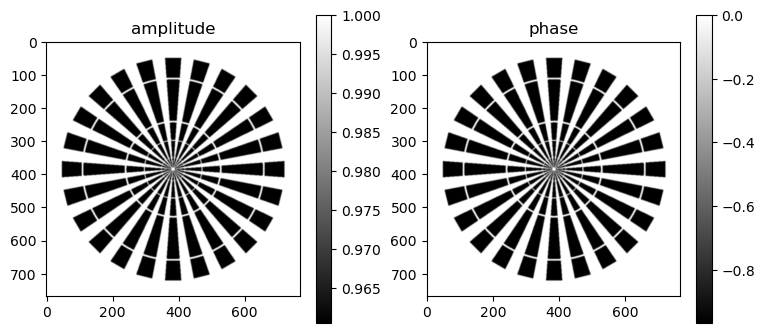

In [3]:
img = np.zeros((ne, ne, 3), np.uint8)
triangle = np.array([(ne//16, ne//2-ne//32), (ne//16, ne//2+ne//32), (ne//2-ne//128, ne//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((ne, ne, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-ne//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+ne//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-ne//2,ne//2),np.arange(-ne//2,ne//2))
x = x/ne*2
y = y/ne*2
# add holes in triangles
circ = (x**2+y**2>0.145)+(x**2+y**2<0.135)
circ *= (x**2+y**2>0.053)+(x**2+y**2<0.05)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
circ *= (x**2+y**2>0.52)+(x**2+y**2<0.5)
# circ *= (x**2+y**2<0.5**2)
star = star*circ/255


# star[ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]=0

v = np.arange(-ne//2,ne//2)/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-30*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 2e-6/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength).astype('complex64')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

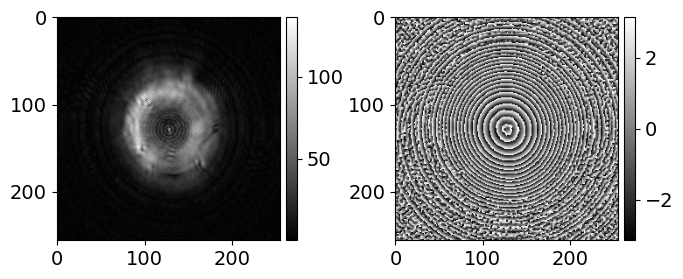

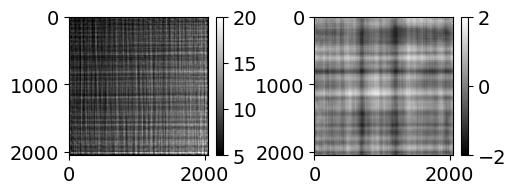

In [ ]:
shifts = np.load(f'{path}/data/positions_px.npy')[0,30:30+npos].astype('float32')
prb = np.load(f'{path}/data/probe.npy')[0]*n
# plt.plot(shifts[:,0],shifts[:,1],'.')
# plt.axis('square')
# plt.show()
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
fig, axs = plt.subplots(1, 2, figsize=(8, 2.9))
im = axs[0].imshow(np.abs(prb), cmap='gray')
fig.colorbar(im, fraction=0.046, pad=0.02)
im = axs[1].imshow(np.angle(prb), cmap='gray')
fig.colorbar(im, fraction=0.046, pad=0.02)
plt.show()

prb_abs = read_tiff(f'../../examples_synthetic/data/prb_id16a/prb_abs_2048.tiff')[0]
prb_phase = read_tiff(f'../../examples_synthetic/data//prb_id16a/prb_phase_2048.tiff')[0]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')

fig, axs = plt.subplots(1, 2, figsize=(5.8, 1.8))
im = axs[0].imshow(np.abs(prb), cmap='gray',vmax=20,vmin=5)
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(np.angle(prb), cmap='gray',vmax=2,vmin=-2)
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

In [5]:
extra = 8

def Lop(psi):
    data = cp.zeros([npos, n, n], dtype='complex64')
    data = np.fft.fft2(psi,norm='ortho')
    return data

def LTop(d):
    psi = cp.zeros([npos, n, n], dtype='complex64')
    psi = cp.fft.ifft2(d,norm='ortho')#*(n**2)
    return psi

def Ex(psi,ix,ex):
    res = cp.empty([ix.shape[0],n+2*ex,n+2*ex],dtype='complex64')
    stx = ne//2-ix[:,1]-n//2-ex
    endx = stx+n+2*ex
    sty = ne//2-ix[:,0]-n//2-ex
    endy = sty+n+2*ex
    for k in range(len(stx)):
        res[k] = psi[sty[k]:endy[k],stx[k]:endx[k]] 
    return res

def ExT(psi,psir,ix,ex):
    stx = ne//2-ix[:,1]-n//2-ex
    endx = stx+n+2*extra
    sty = ne//2-ix[:,0]-n//2-ex
    endy = sty+n+2*extra
    for k in range(len(stx)):
        psi[sty[k]:endy[k],stx[k]:endx[k]] += psir[k]
    return psi

def S(psi,p):
    n = psi.shape[-1]        
    res = cp.pad(psi, ((0, 0), (n//2, n//2), (n//2, n//2)),'constant')
    x = cp.fft.fftfreq(2*n).astype('float32')
    [y, x] = cp.meshgrid(x, x)
    pp = cp.exp(-2*cp.pi*1j * (y*p[:, 1, None, None]+x*p[:, 0, None, None])).astype('complex128')
    res = cp.fft.ifft2(pp*cp.fft.fft2(res))
    res = res[:, n//2:-n//2, n//2:-n//2]
    return res

def Sop(psi,ix,x,ex):
    data = cp.zeros([x.shape[1], n, n], dtype='complex64')
    psir = Ex(psi,ix,ex)     
    psir = S(psir,x)
    data = psir[:, ex:-ex, ex:-ex]
    return data

def STop(d,ix,x,ex):
    psi = cp.zeros([ne, ne], dtype='complex64')
    p = cp.asarray(x)                
    dr = cp.pad(d, ((0, 0), (ex, ex), (ex, ex)),'constant')
    dr = S(dr,-p)        
    ExT(psi,dr,ix,ex)
    return psi

# adjoint tests
arr1 = (cp.random.random([ne,ne])+1j*cp.random.random([ne,ne])).astype('complex64')
shifts = cp.array(shifts)
ishifts = shifts.astype('int32')
fshifts = shifts-ishifts
extra = 8
arr2 = Sop(arr1,ishifts,fshifts,extra)
arr3 = STop(arr2,ishifts,fshifts,extra)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = (cp.random.random([npos,n,n])+1j*cp.random.random([npos,n,n])).astype('complex64')
arr2 = Lop(arr1)
arr3 = LTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')




(43709.7578125+0.0013884007930755615j)==
(43709.75465421309-1.6633576487648818e-15j)
(43683.3125+0.0013244807487353683j)==
(43683.30859375+1.16595094823424e-06j)


# generate data

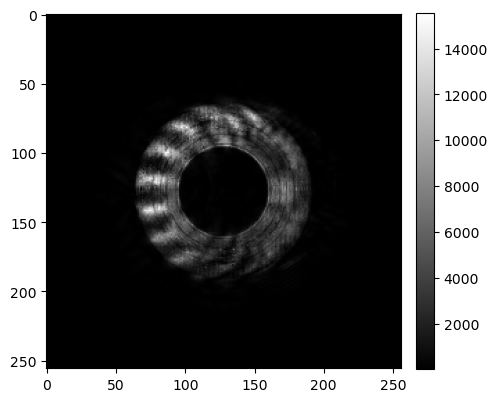

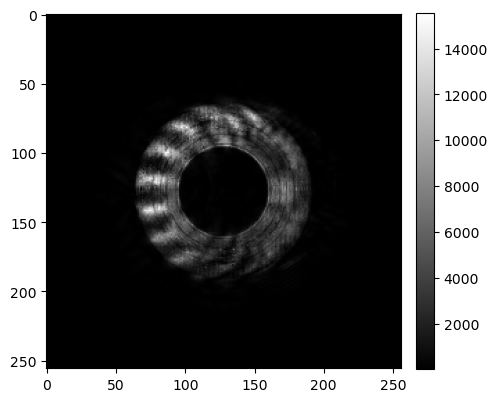

In [6]:
ishifts = shifts.astype('int32')
fshifts = shifts-ishifts
extra = 8
psi = cp.array(psi)
prb = cp.array(prb)
data = np.fft.fftshift(np.abs(Lop(prb*Sop(psi,ishifts,fshifts,extra)))**2,axes=(-1,-2))
# data = data.astype('int32').astype('float32')
mshow(np.abs(data[0]),show)
mshow(np.abs(data[-1]),show)
np.save(f'{path}/data/data',data.get())
np.save(f'{path}/data/gen_prb',prb.get())
np.save(f'{path}/data/gen_shifts',shifts.get())
np.save(f'{path}/data/psi',psi.get())
